# Explore Non-Zero mean in ARCTERX

In [24]:
from importlib import reload
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from cugn import gliderdata
from cugn import gliderpairs
from cugn import io as cugn_io
from cugn import utils as cugn_utils
from cugn import plotting as cugn_plotting

In [1]:
%matplotlib ipympl

In [25]:
Sn_lbls = cugn_plotting.Sn_lbls

# Load + calculate

In [5]:
max_time=10. 
avoid_same_glider=False 
nbins=20
iz = 5
dataset = 'ARCTERX'

In [8]:
rbins = 10**np.linspace(0., np.log10(400), nbins) # km

# Load dataset
gData = gliderdata.load_dataset(dataset)

# Cut on valid velocity data 
gData = gData.cut_on_good_velocity()

# Generate pairs
gPairs = gliderpairs.GliderPairs(
    gData, max_time=max_time, 
    avoid_same_glider=avoid_same_glider)

In [11]:
gPairs.calc_delta(iz, variables)
gPairs.calc_Sn(variables)

Sn_dict = gPairs.calc_Sn_vs_r(rbins, nboot=10000)
gPairs.calc_corr_Sn(Sn_dict) 

In [14]:
gPairs.add_meta(Sn_dict)

In [15]:
Sn_dict.keys()

dict_keys(['config', 'r', 'S1_duL', 'std_S1_duL', 'med_S1_duL', 'err_S1_duL', 'S2_duL**2', 'std_S2_duL**2', 'err_S2_duL**2', 'S3_duLduLduL', 'std_S3_duLduLduL', 'err_S3_duLduLduL', 'S2corr_duL**2', 'S3corr_duLduLduL'])

In [19]:
Sn_dict['config'].keys()

dict_keys(['variables', 'N', 'max_dist', 'max_time', 'avoid_self', 'dataset', 'iz', 'creation_date', 'created_by'])

# Mean

In [9]:
variables = 'duLduLduL'
Skeys = ['S1_duL', 'S2_duL**2', 'S3_'+variables]

In [20]:
minN = 10
goodN = Sn_dict['config']['N'] > minN

## Plot

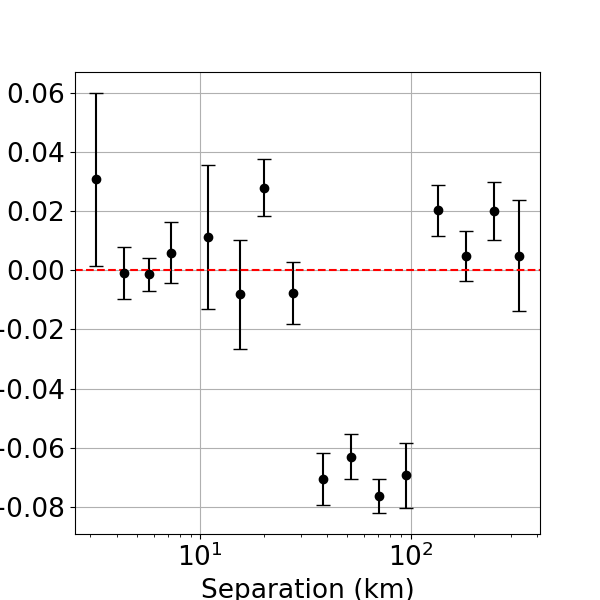

In [49]:
reload(cugn_plotting)
clr = 'k'

fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()

n=0
Skey = Skeys[n] 
ax.errorbar(Sn_dict['r'][goodN], 
            Sn_dict[Skey][goodN], 
            yerr=Sn_dict['err_'+Skey][goodN],
            color=clr,
            fmt='o', capsize=5)  # fmt defines marker style, capsize sets error bar cap length

# Corrected
if n > 0:
    corr_key = Skey[0:2]+'corr'+Skey[2:]
    ax.plot(Sn_dict['r'][goodN], 
            Sn_dict[corr_key][goodN],  
            'x',
            color=clr)
elif 'med_S1' in Sn_dict.keys():
    ax.plot(Sn_dict['r'][goodN], Sn_dict['med_S1'][goodN],  
            'x', color=clr)


ax.set_xscale('log')
#
ax.set_xlabel('Separation (km)')
ax.set_ylabel(Sn_lbls[Skey])

# Label time separation
if n == 2:
    same_glider = 'True' if avoid_same_glider else 'False'
    ax.text(0.1, 0.8, 
            f'{dataset}\n depth = {(iz+1)*10} m\nAvoid same glider? {same_glider}\n {variables}', 
        transform=ax.transAxes, fontsize=16, ha='left')
# 0 line
ax.axhline(0., color='red', linestyle='--')

cugn_plotting.set_fontsize(ax, 19) 
ax.grid()

----

# Examine a few of these negative bins

## Isolate

In [33]:
neg_idx = np.arange(11,15)

In [34]:
Sn_dict[Skey][neg_idx]

array([-0.07067644, -0.06303289, -0.07644347, -0.06933247])

In [35]:
Sn_dict['config']['N'][neg_idx]

array([ 572,  754, 1184,  382])

In [74]:
ss = neg_idx[1]

## Distributions

In [75]:
in_r = (gPairs.r > rbins[ss]) & (gPairs.r <= rbins[ss+1])
np.sum(in_r)

754

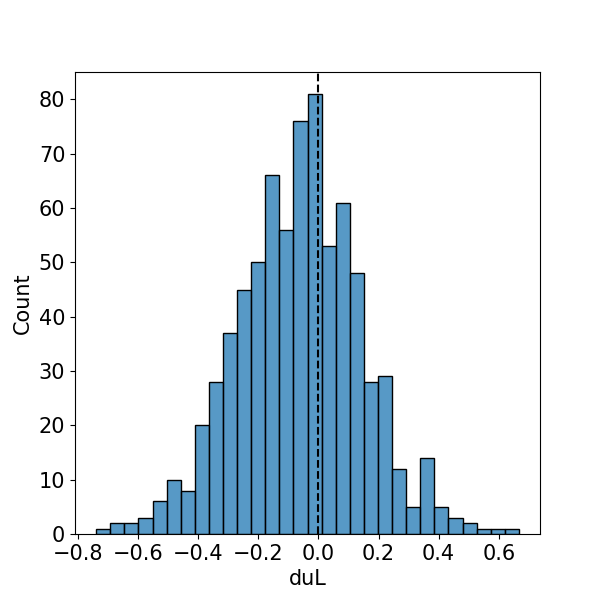

In [76]:
fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()

sns.histplot(gPairs.S1[in_r], bins=30, ax=ax)
#
ax.axvline(0., color='k', ls='--')
# Label
ax.set_xlabel('duL')
cugn_plotting.set_fontsize(ax, 15.)
plt.show()

## Locations

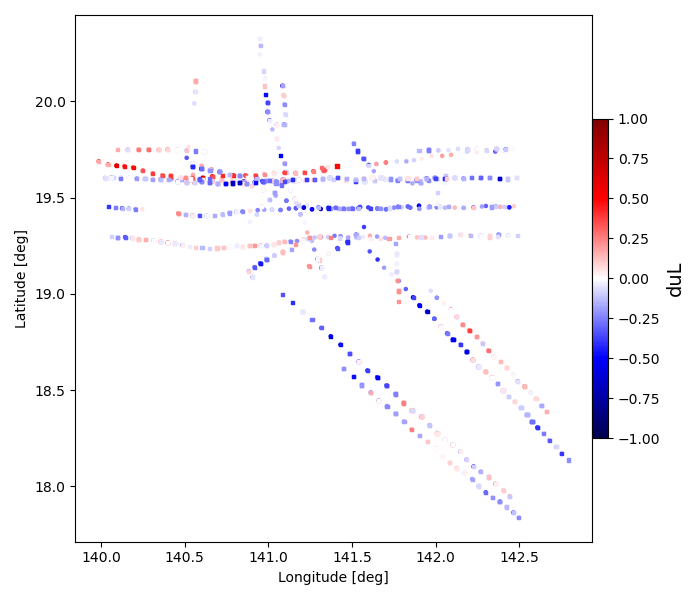

In [77]:
fig = plt.figure(figsize=(7,6))
plt.clf()
ax_ll = plt.gca()

# 
for tt in [0,1]:
    m = 'o' if tt == 0 else 's'
    scatter = ax_ll.scatter(gPairs.data('lon', tt)[in_r],  
              gPairs.data('lat', tt)[in_r], 
              c=gPairs.S1[in_r],
                            marker=m,
              cmap='seismic',
               vmin=-1., vmax=1.,
              s=5)#, label=f'MID={mid}')

# Color
cb = plt.colorbar(scatter, pad=0., fraction=0.030)
cb.set_label('duL', fontsize=14)

ax_ll.set_xlabel('Longitude [deg]')
ax_ll.set_ylabel('Latitude [deg]')
#
plt.tight_layout()
plt.show()

----

In [55]:
gPairs.data('lat', 1).size

7001

In [45]:
np.sum(Sn_dict['config']['N'])

7001